In [224]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

In [22]:
FOLDER_PATH = "D:\\Google Drive\\Catherning Folder\\THU\\Thesis\\Recipe datasets\\scirep-cuisines-detail"
FILES = ["allr_recipes.txt","epic_recipes.txt","menu_recipes.txt"]

In [185]:
recipes = []
for file in FILES:
    with open(os.path.join(FOLDER_PATH,file)) as f:
        for i,recipe in enumerate(f):
            data = recipe.strip('\n').split('\t')
            recipes.append({"cuisine":data[0],"id":i,"ingredients":data[1:]})
        
df_train = pd.DataFrame(recipes)

### Data cleaning

In [186]:
# Fusion of the same cuisines
df_train=df_train.replace("Mexico","Mexican")
df_train=df_train.replace("mexico","Mexican")
df_train=df_train.replace("chinese","Chinese")
df_train=df_train.replace("China","Chinese")
df_train=df_train.replace("France","French")
df_train=df_train.replace("japanese","Japanese")
df_train=df_train.replace("Japan","Japanese")
df_train=df_train.replace("Thailand","Thai")
df_train=df_train.replace("German","Germany")
df_train=df_train.replace("India","Indian")
df_train=df_train.replace("Israel","Jewish")
df_train=df_train.replace("italian","Italian")
df_train=df_train.replace("Italy","Italian")
df_train=df_train.replace("Scandinavia","Scandinavian")
df_train=df_train.replace("Vietnam","Vietnamese")
df_train=df_train.replace("Korea","Korean")
df_train=df_train.replace("korean","Korean")
df_train=df_train.replace("EasternEuropean_Russian","Eastern-Europe")
df_train=df_train.replace('Spain','Spanish_Portuguese')
df_train

,cuisine,id,ingredients
0,Canada,0,"[egg, yeast, wheat, milk, lard]"
1,Canada,1,"[pork, carrot, pea, onion, potato]"
2,Canada,2,[maple_syrup]
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget..."
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po..."
...,...,...,...
57686,Italian,2453,"[kiwi, olive_oil, clam, white_wine, orange, sa..."
57687,Italian,2454,"[tomato, butter, beef, onion, red_wine, black_..."
57688,Italian,2455,"[vegetable, wheat, egg, cheese, olive_oil]"
57689,Italian,2456,"[tomato, clam, black_pepper, parsley, celery, ..."


# Data analysis

Italian                  3250
Mexican                  2390
French                   1264
Asian                    1176
east_asian                951
Korean                    799
Canada                    774
Indian                    598
western                   450
Chinese                   442
Spanish_Portuguese        366
Southern_SoulFood         346
Jewish                    329
Japanese                  320
Thai                      289
Mediterranean             289
Germany                   289
UK-and-Ireland            282
Scandinavian              250
MiddleEastern             248
Central_SouthAmerican     241
Eastern-Europe            235
Greek                     225
English_Scottish          204
American                  200
Caribbean                 183
Eastern_Europe            146
Cajun_Creole              146
Moroccan                  137
African                   115
Southwestern              108
South-America             103
Vietnamese                 95
Irish     

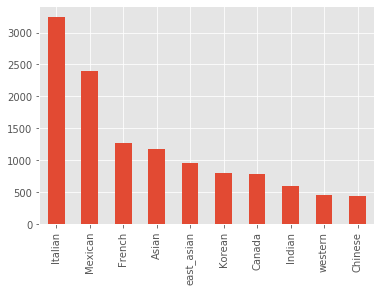

In [133]:
%matplotlib inline

plt.style.use('ggplot')
df_train['cuisine'].value_counts().head(10).plot(kind='bar')

df_train['cuisine'].value_counts()

Results are worse when we remove American recipes!
Check what exactly are those results
See if we should remove american, if yes, how to improve score ???

### Counter for ingredients

In [134]:
counters = {}
for cuisine in df_train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (df_train['cuisine'] == cuisine)
    for ingredients in df_train[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [135]:
counters['French'].most_common(10)

[('butter', 633),
 ('egg', 558),
 ('wheat', 472),
 ('olive_oil', 353),
 ('cream', 347),
 ('garlic', 335),
 ('onion', 323),
 ('milk', 260),
 ('black_pepper', 259),
 ('parsley', 237)]

In [136]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
Canada,wheat,butter,egg,onion,garlic,milk,black_pepper,cane_molasses,vegetable_oil,pepper
Turkey,garlic,onion,tomato,butter,wheat,yogurt,olive_oil,bell_pepper,pepper,egg
Caribbean,onion,garlic,vegetable_oil,black_pepper,tomato,olive_oil,pepper,cayenne,bell_pepper,chicken
Bangladesh,onion,cayenne,vegetable_oil,turmeric,garlic,cilantro,coriander,beef,potato,cardamom
Indian,cumin,turmeric,onion,coriander,cayenne,garlic,ginger,vegetable_oil,pepper,fenugreek
French,butter,egg,wheat,olive_oil,cream,garlic,onion,milk,black_pepper,parsley
Italian,olive_oil,garlic,tomato,onion,basil,parmesan_cheese,macaroni,egg,butter,black_pepper
Jewish,egg,wheat,butter,onion,vegetable_oil,olive_oil,black_pepper,cinnamon,garlic,lemon_juice
Korean,garlic,scallion,cayenne,soy_sauce,sesame_oil,black_pepper,rice,soybean,roasted_sesame_seed,vegetable
Iran,onion,tomato,yogurt,black_pepper,garlic,cardamom,olive_oil,walnut,vegetable_oil,dill


In [187]:
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)
df_train.head()

,cuisine,id,ingredients,all_ingredients
0,Canada,0,"[egg, yeast, wheat, milk, lard]",egg;yeast;wheat;milk;lard
1,Canada,1,"[pork, carrot, pea, onion, potato]",pork;carrot;pea;onion;potato
2,Canada,2,[maple_syrup],maple_syrup
3,Canada,3,"[wheat, yeast, almond, honey, oat, date, veget...",wheat;yeast;almond;honey;oat;date;vegetable_oi...
4,Canada,4,"[butter, lovage, clam, wheat, onion, thyme, po...",butter;lovage;clam;wheat;onion;thyme;potato;ye...


In [138]:
df_train['all_ingredients'].str.contains('garlic').value_counts()

False    9888
True     7853
Name: all_ingredients, dtype: int64

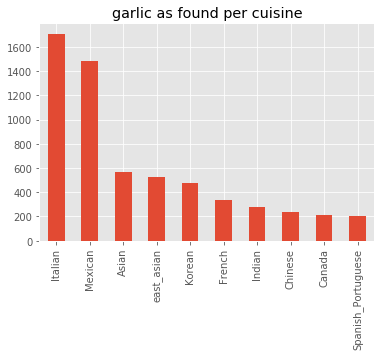

In [139]:
indices = df_train['all_ingredients'].str.contains('garlic')
df_train[indices]['cuisine'].value_counts().head(10).plot(kind='bar',
                                                 title='garlic as found per cuisine')

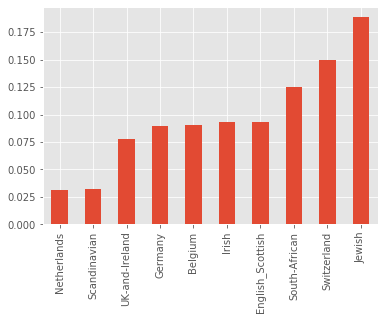

In [76]:
relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
relative_freq.sort_values(inplace=True)
relative_freq.head(10).plot(kind='bar')

In [77]:
unique = np.unique(top10.values.ravel())
unique.shape

(73,)

In [78]:
# spot ingredients which have a high degree of uniqueness

# fig, axes = plt.subplots(8, 8, figsize=(20, 20))
# for ingredient, ax_index in zip(unique, range(64)):
#     indices = df_train['all_ingredients'].str.contains(ingredient)
#     relative_freq = (df_train[indices]['cuisine'].value_counts() / df_train['cuisine'].value_counts())
#     relative_freq.head(10).plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)

### More data cleaning by cuisine and prepare for classification

In [188]:
# # remove most americans for now, to have better distribution of cuisines
# american_df = df_train[df_train["cuisine"]=="American"].sample(frac=0.9)
# df_train=df_train[~df_train.isin(american_df).all(1)]

# df_train = df_train[(df_train["cuisine"]!="American")]

In [189]:
cv = CountVectorizer()

X = cv.fit_transform(df_train['all_ingredients'].values)
X
# 57691 recipes, 383 ingredients

<57691x383 sparse matrix of type '<class 'numpy.int64'>'
	with 476250 stored elements in Compressed Sparse Row format>

### PCA

In [190]:
x_american=cv.fit_transform(df_train[df_train["cuisine"]=="American"]['all_ingredients'].values)
x_american

<40150x354 sparse matrix of type '<class 'numpy.int64'>'
	with 318499 stored elements in Compressed Sparse Row format>

In [191]:
df_train.loc[df_train["cuisine"]=="American","american_id"]=[i for i in range(x_american.shape[0])]
df_train[df_train["cuisine"]=="American"]

,cuisine,id,ingredients,all_ingredients,american_id
4437,American,4437,"[tomato, honey, chicken, mustard, onion]",tomato;honey;chicken;mustard;onion,0.0
4438,American,4438,"[feta_cheese, black_pepper, ginger, pecan, chi...",feta_cheese;black_pepper;ginger;pecan;chicken;...,1.0
4439,American,4439,"[cocoa, milk]",cocoa;milk,2.0
4440,American,4440,"[tomato, olive_oil, parmesan_cheese, macaroni,...",tomato;olive_oil;parmesan_cheese;macaroni;basi...,3.0
4441,American,4441,"[olive_oil, pepper, onion, thyme, potato, whit...",olive_oil;pepper;onion;thyme;potato;white_wine...,4.0
...,...,...,...,...,...
49622,American,7797,"[tomato, vinegar, okra, onion, lima_bean, corn...",tomato;vinegar;okra;onion;lima_bean;corn;cayen...,40145.0
49623,American,7798,"[orange, olive_oil, pork, garlic, oregano]",orange;olive_oil;pork;garlic;oregano,40146.0
49624,American,7799,"[butter, cane_molasses, wheat, vanilla, walnut...",butter;cane_molasses;wheat;vanilla;walnut;coco...,40147.0
49625,American,7800,"[butter, cane_molasses, wheat, blueberry, milk...",butter;cane_molasses;wheat;blueberry;milk_fat;...,40148.0


In [192]:
K_clusters=200

reduced_data = TruncatedSVD(n_components=2).fit_transform(x_american)
kmeans = MiniBatchKMeans(n_clusters=K_clusters, n_init=10)
kmeans.fit(reduced_data)
kmeans.labels_

array([105, 197,  90, ..., 180,  53, 181])

In [193]:
closest,_ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reduced_data)
if np.unique(closest).shape[0]!=K_clusters:
    print(np.unique(closest).shape)
    print("https://stackoverflow.com/questions/21660937/get-nearest-point-to-centroid-scikit-learn")

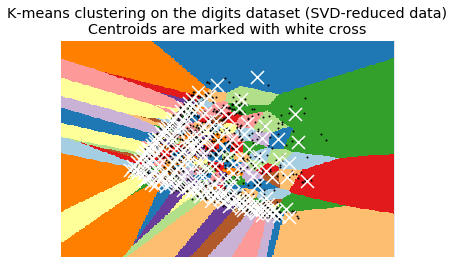

In [194]:
reduced_data = reduced_data[:2000]

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (SVD-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [195]:
df_train=df_train[(df_train["american_id"].isin(closest)) ^ (df_train["american_id"].isnull())]
X = cv.fit_transform(df_train['all_ingredients'].values)
X

<17741x366 sparse matrix of type '<class 'numpy.int64'>'
	with 159412 stored elements in Compressed Sparse Row format>

In [196]:
df_train.to_pickle(os.path.join(FOLDER_PATH,"cleaned_data.pkl"))

In [197]:
print(list(cv.vocabulary_.keys())[:100])

['egg', 'yeast', 'wheat', 'milk', 'lard', 'pork', 'carrot', 'pea', 'onion', 'potato', 'maple_syrup', 'almond', 'honey', 'oat', 'date', 'vegetable_oil', 'whole_grain_wheat_flour', 'butter', 'lovage', 'clam', 'thyme', 'black_pepper', 'parsley', 'ginger', 'bay', 'celery', 'cinnamon', 'mustard', 'cane_molasses', 'raisin', 'cream', 'asparagus', 'olive_oil', 'pepper', 'garlic', 'tomato', 'cilantro', 'tea', 'jasmine', 'vegetable', 'brown_rice', 'lemon_juice', 'soy_sauce', 'white_wine', 'chicken', 'vanilla', 'rice', 'mushroom', 'chicken_broth', 'basil', 'porcini', 'mozzarella_cheese', 'tuna', 'lemon', 'beef', 'fish', 'cocoa', 'green_bell_pepper', 'oregano', 'rosemary', 'coffee', 'banana', 'squash', 'egg_noodle', 'bell_pepper', 'cheddar_cheese', 'broccoli', 'cayenne', 'scallion', 'lettuce', 'cucumber', 'cream_cheese', 'melon', 'cranberry', 'peanut', 'nut', 'chickpea', 'yogurt', 'bread', 'tabasco_pepper', 'cod', 'bacon', 'pimento', 'black_tea', 'grapefruit', 'orange_juice', 'pineapple', 'vinegar

In [198]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
print(enc.classes_)
enc.classes_.shape

['African' 'American' 'Asian' 'Austria' 'Bangladesh' 'Belgium'
 'Cajun_Creole' 'Canada' 'Caribbean' 'Central_SouthAmerican' 'Chinese'
 'East-African' 'Eastern-Europe' 'English_Scottish' 'French' 'Germany'
 'Greek' 'Indian' 'Indonesia' 'Iran' 'Irish' 'Italian' 'Japanese' 'Jewish'
 'Korean' 'Lebanon' 'Malaysia' 'Mediterranean' 'Mexican' 'MiddleEastern'
 'Moroccan' 'Netherlands' 'North-African' 'Pakistan' 'Philippines'
 'Portugal' 'Scandinavian' 'South-African' 'South-America'
 'Southern_SoulFood' 'Southwestern' 'Spanish_Portuguese' 'Switzerland'
 'Thai' 'Turkey' 'UK-and-Ireland' 'Vietnamese' 'West-African' 'asian'
 'east_asian' 'western']


(51,)

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 31,
 1: 42,
 2: 226,
 3: 2,
 5: 2,
 6: 27,
 7: 144,
 8: 29,
 9: 52,
 10: 82,
 11: 4,
 12: 73,
 13: 34,
 14: 235,
 15: 59,
 16: 47,
 17: 117,
 18: 1,
 19: 5,
 20: 13,
 21: 675,
 22: 66,
 23: 73,
 24: 156,
 25: 8,
 26: 6,
 27: 53,
 28: 497,
 29: 57,
 30: 24,
 31: 11,
 32: 8,
 33: 4,
 34: 13,
 35: 6,
 36: 49,
 37: 4,
 38: 22,
 39: 68,
 40: 23,
 41: 71,
 42: 5,
 43: 51,
 44: 1,
 45: 61,
 46: 20,
 49: 184,
 50: 108}

# Logistic Regression

In [221]:
parameters = {'C':[0.1,0.3,0.6,0.9,1],
              'solver' : ('newton-cg', 'liblinear')}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
logistic = LogisticRegression(class_weight="balanced",multi_class="auto",max_iter=150,warm_start=True)

clf = GridSearchCV(logistic, parameters, cv=4,scoring=scoring)
clf.fit(X_train, y_train)

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=150, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.3, 0.6, 0.9, 1],
                         'solver': ('newton-cg', 'liblinear')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

In [222]:
# pd.DataFrame(clf.cv_results_)
print(clf.best_estimator_)
clf.best_score_

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=True)


0.4403589316754359

In [223]:
clf.best_estimator_.score(X_test, y_test)

0.40095801634263173

## Results

In [ ]:
plt.figure(figsize=(10, 10))

cm = confusion_matrix(y_test, logistic.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = df_train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, enc.classes_, rotation=90)
plt.yticks(tick_marks, enc.classes_)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
y_pred = logistic.predict(X_test)

print(classification_report(y_test, y_pred, labels=[i for i in range(69)], target_names=enc.classes_))

# Random Forest

much slower and a bit worse

In [233]:
parameters = {'max_depth':(None,3,5,8)}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
rf = RandomForestClassifier(n_estimators=200, random_state=123,class_weight="balanced")

clf = GridSearchCV(rf, parameters, cv=4,scoring=scoring)
clf.fit(X_train, y_train)

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             i

In [234]:
print(clf.best_estimator_)
clf.best_score_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


0.3851489793118264

In [235]:
clf.best_estimator_.score(X_test, y_test)

0.42265426880811496

## Results

In [155]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, labels=[i for i in range(69)], target_names=cuisines))

                       precision    recall  f1-score   support

              Italian       0.00      0.00      0.00        29
              Mexican       0.00      0.00      0.00         1
               French       0.37      0.41      0.39       233
                Asian       0.00      0.00      0.00         4
           east_asian       0.00      0.00      0.00         3
               Korean       0.00      0.00      0.00         1
               Canada       0.50      0.25      0.33        24
               Indian       0.27      0.16      0.20       145
              western       0.50      0.17      0.26        35
              Chinese       0.11      0.05      0.07        39
   Spanish_Portuguese       0.08      0.07      0.07        91
    Southern_SoulFood       0.00      0.00      0.00         1
               Jewish       0.38      0.24      0.30        54
             Japanese       0.00      0.00      0.00        23
                 Thai       0.33      0.11      0.17  

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 69, does not match size of target_names, 52
  .format(len(labels), len(target_names))
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# SVM

In [236]:
parameters = {'loss':('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
              }
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
sgd = SGDClassifier(class_weight="balanced",early_stopping=True,warm_start=True)

clf = GridSearchCV(sgd, parameters, cv=4,scoring=scoring)
clf.fit(X_train, y_train)

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=True, epsilon=0.1, eta0=0.0,
                                     fit_intercept=True, l1_ratio=0.15,
                                     learning_rate='optimal', loss='hinge',
                                     max_iter=1000, n_iter_no_change=5,
                                     n_jobs=None, penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'loss': ('hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron')},
             pre_dispatch='2*n_jobs', refit=True, return_tra

In [237]:
print(clf.best_estimator_)
clf.best_score_

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=True)


0.40447709533483994

In [238]:
clf.best_estimator_.score(X_test, y_test)

0.3544660467737391